In [1]:
%matplotlib inline

# Introduction to Deep Learning with Keras and TensorFlow



To help you understand the fundamentals of deep learning, this demo will walk through the basic steps of building two toy models for classifying handwritten numbers with accuracies surpassing 95%. The first model will be a basic fully-connected neural network, and the second model will be a deeper network that introduces the concepts of convolution and pooling.

## The Task for the AI

Our goal is to construct and train an artificial neural network on thousands of images of handwritten digits so that it may successfully identify others when presented. The data that will be incorporated is the MNIST database which contains 60,000 images for training and 10,000 test images. We will use the Keras Python API with TensorFlow as the backend.

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

## Prerequisite Python Modules

First, some software needs to be loaded into the Python environment.

In [2]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt             # MATLAB like plotting routines
import random                        # for generating random numbers

from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used
from keras.layers import Dense,Activation,Dropout,Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten # Types of layers to be used in our model
from keras.utils import to_categorical     # NumPy related tools

## Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [3]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel test images
(X_train, y_train), (X_test, y_test) = mnist.load_data()


print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

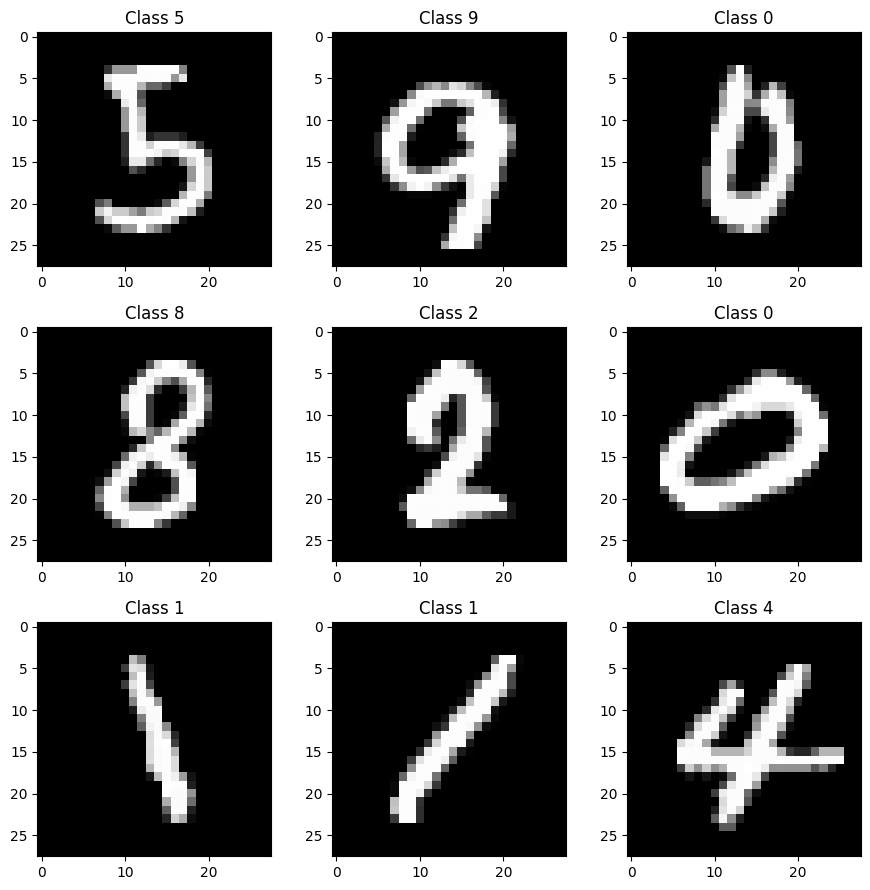

In [4]:
plt.rcParams['figure.figsize'] = (9,9) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [5]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0  156  253  170    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0   73  207  252  128    0    0    0    0  0  0  
0  0  0  0  0  0    0    0    0    0    0   73  160   37    0    0    0    0  253  252  246   92    0    0    0    0  0  0  


Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.



# Introducing Convolution! What is it?

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

<img src = 'convolution.gif' >

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

<img src = 'kernels.png' >

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

<img src = 'max_pooling.png' >

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

<img src = 'go_deeper.jpg' >

In [6]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel test images
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')               # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28, 1)
y_train shape (60000,)
X_test shape (10000, 28, 28, 1)
y_test shape (10000,)


In [7]:
from sklearn.model_selection import train_test_split
TRAIN_RATIO=0.8
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(1-TRAIN_RATIO))

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_val shape", X_val.shape)
print("y_val shape", y_val.shape)


X_train shape (48000, 28, 28, 1)
y_train shape (48000,)
X_val shape (12000, 28, 28, 1)
y_val shape (12000,)


We then modify our classes (unique digits) to be in the one-hot format, i.e.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
etc.
```

If the final output of our network is very close to one of these classes, then it is most likely that class. For example, if the final output is:

```
[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]
```
then it is most probable that the image is that of the digit `1`.

In [8]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = to_categorical(y_train, nb_classes)
Y_val = to_categorical(y_val, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

## Building a "Deep" Convolutional Neural Network

<img src = 'CNN.png' >

In [28]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(16, (1, 1), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(Activation('relu'))                  # activation
model.add(MaxPooling2D(pool_size=(2,2)))


# Convolution Layer 2
model.add(Conv2D(80, (1, 1)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(Activation('relu'))                        # activation
model.add(MaxPooling2D(pool_size=(2,2)))       # Pool the max values over a 2x2 kernel

model.add(Flatten())                              # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 3
model.add(Dense(1024))                                # 512 FCN nodes
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 4
                                     # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        32        
                                                                 
 activation_8 (Activation)   (None, 28, 28, 16)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 80)        1360      
                                                                 
 activation_9 (Activation)   (None, 14, 14, 80)        0         
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 7, 7, 80)          0         
 g2D)                                                 

In [30]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [31]:
model.fit(X_train, Y_train,
          validation_data=(X_val,Y_val),
          batch_size=120, epochs=3,
          verbose=1)

Epoch 1/3
400/400 [==============================] - 5s 8ms/step - loss: 0.5099 - accuracy: 0.8350 - val_loss: 0.3325 - val_accuracy: 0.8893
Epoch 2/3
400/400 [==============================] - 2s 6ms/step - loss: 0.2838 - accuracy: 0.9088 - val_loss: 0.2483 - val_accuracy: 0.9197
Epoch 3/3
400/400 [==============================] - 2s 6ms/step - loss: 0.2121 - accuracy: 0.9324 - val_loss: 0.2311 - val_accuracy: 0.9237


In [38]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1])

Test accuracy: 0.9399999976158142


In [ ]:
進階

In [ ]:
進階

In [ ]:
進階

In [43]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

val_gen = ImageDataGenerator()

In [44]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
val_generator = val_gen.flow(X_val, Y_val, batch_size=128)


In [48]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=48000//128, epochs=3, verbose=1,
                    validation_data=val_generator, validation_steps=12000//128)

<ipython-input-48-dc4075b08c76>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=48000//128, epochs=3, verbose=1,


Epoch 1/3
375/375 [==============================] - 18s 48ms/step - loss: 0.1972 - accuracy: 0.9364 - val_loss: 0.1567 - val_accuracy: 0.9462
Epoch 2/3
375/375 [==============================] - 17s 46ms/step - loss: 0.1889 - accuracy: 0.9381 - val_loss: 0.1442 - val_accuracy: 0.9540
Epoch 3/3
375/375 [==============================] - 24s 64ms/step - loss: 0.1802 - accuracy: 0.9427 - val_loss: 0.1630 - val_accuracy: 0.9466


In [49]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 3ms/step - loss: 0.1514 - accuracy: 0.9489
Test score: 0.15144851803779602
Test accuracy: 0.9488999843597412


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [50]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predicted_classes = np.argmax(model.predict(X_test), axis=-1)

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

313/313 [==============================] - 1s 2ms/step


In [23]:
predicted_classes

array([7, 2, 1, ..., 4, 5, 6])

In [24]:
len(correct_indices)/(len(correct_indices)+len(incorrect_indices))

0.9923

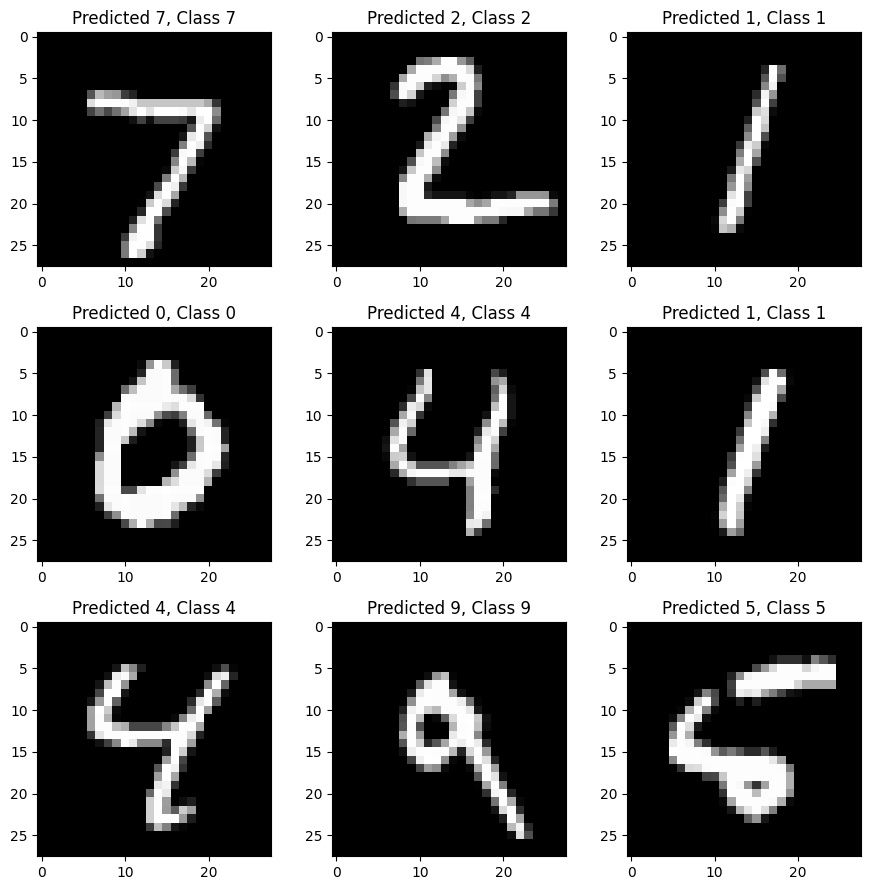

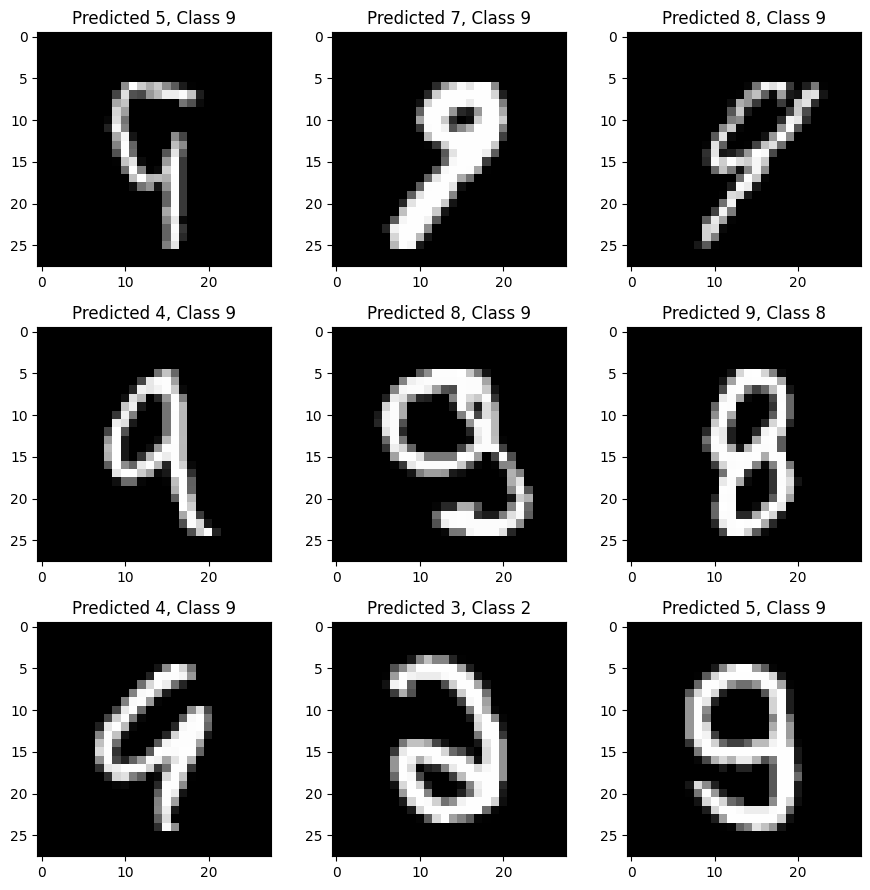

In [51]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()